# Classifying S3 Data Sensitivity with Machine Learning
This notebook demonstrates how to categorize S3 data objects as sensitive or non-sensitive by analyzing object metadata with Python and scikit-learn.

## 1. Business Problem
With data stored in S3 buckets, we need an automated way to identify sensitive data and enforce security policies. Manually classifying data does not scale.

We will build a proof of concept to show how object metadata like bucket names and access patterns can be used to train an ML model to classify sensitivity.

## 2. Sample Data
We create sample metadata for a few S3 objects containing attributes like bucket name and last accessed date:

In [1]:
import pandas as pd
import sns

data = [{'s3bucket': 'financial-data', 'days_since_access': 2291, 'data_size_gb': 0.02},
        {'s3bucket': 'model-data', 'days_since_access': 119, 'data_size_gb': 0.02},
        {'s3bucket': 'log-files', 'days_since_access': 2733, 'data_size_gb': 0.01},
        {'s3bucket': 'airflow-genie', 'days_since_access': 2291, 'data_size_gb': 0.02},
        {'s3bucket': 'searchmetadata', 'days_since_access': 119, 'data_size_gb': 0.02},
        {'s3bucket': 'digital-archive-east', 'days_since_access': 138, 'data_size_gb': 15.92}]

df = pd.DataFrame(data)
display(df)

,s3bucket,days_since_access,data_size_gb
0,financial-data,2291,0.02
1,model-data,119,0.02
2,log-files,2733,0.01
3,airflow-genie,2291,0.02
4,searchmetadata,119,0.02
5,digital-archive-east,138,15.92


## 3. Feature Engineering
We transform the text data about S3 bucket names into numeric vectors using scikit-learn's TfidfVectorizer. This encoder converts text into tf-idf vectors.

TfidfVectorizer removes stopwords, applies tokenization, ngram generation, and calculates document frequencies to encode text data.

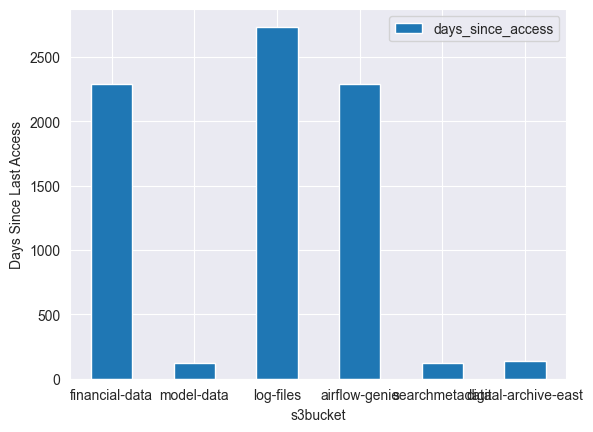

In [2]:
import matplotlib.pyplot as plt

ax = df.plot.bar(x='s3bucket', y='days_since_access', rot=0)
ax.set_ylabel("Days Since Last Access")
plt.show()

Below heatmap visualization shows the **tf-idf vector values** for each feature (token) from the `TfidfVectorizer` text encoding process.

Specifically:

* The x-axis contains the **feature names** - these are the **individual text tokens** (terms) extracted from the S3 bucket names after preprocessing (lowercasing, stopword removal etc).

* The y-axis corresponds to the **individual S3 records** from our sample metadata.

* Each cell shows the **tf-idf weight** calculated by the vectorizer for that particular token in that specific document.

* **Brighter colors** indicate a **higher tf-idf value** and hence a greater relevance for that term in the document.

So in summary, the heatmap gives us:

- A glance of the most "important" words in characterizing each document based on word frequencies.

- This is a vectorized numeric representation of the original text data.

- Shows which terms distinguish documents from one another.

Analyzing these high-weight features can give insight into patterns that help predict sensitivity - e.g financial tokens being more indicative of confidential data.


Text(0.5, 23.52222222222222, 'Tokens')

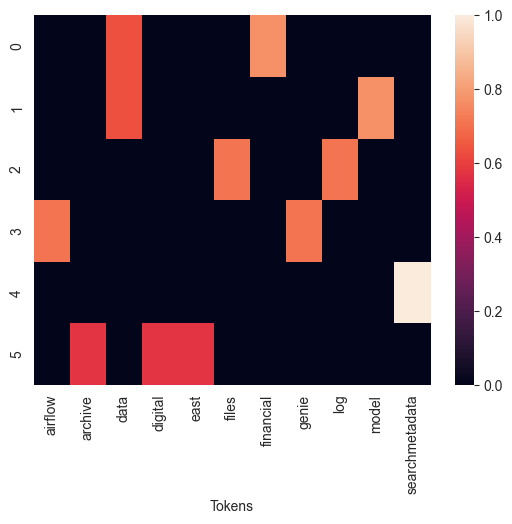

In [3]:
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['s3bucket'])
feature_names = vectorizer.get_feature_names_out()

ax = sns.heatmap(X.toarray(), xticklabels=feature_names)
plt.xlabel("Tokens")


## 4. Classification Model

With numeric vectors representing the S3 metadata, we can now train a classification algorithm to predict sensitivity labels. 

For this, we will use the **Multinomial Naive Bayes** algorithm. 

#### Overview

The Multinomial NB model is a common choice for document classification tasks. It applies Bayes' theorem with a strong assumption of **word independence** to calculate probabilities of classes.

The advantages are that it is **simple, fast to train, and works well for text data.**

#### Mathematical Details

- Uses multinomial distributions to represent word counts
- Predicts classes using Bayes' rule to calculate posterior probabilities:

$\Large{P(c_k|d)=\frac{P(c_k)\prod_{i=1}^{N_{words}} P(w_i|c_k)^{n_{i}}}{P(d)}}$

where $n_{i,j}$ is the number of times word $w_i$ appeared in training document $d_j$.

We implement the model in Python as:  

In [4]:
from sklearn.naive_bayes import MultinomialNB

# Vectorize text
X = vectorizer.fit_transform(df['s3bucket'])

# Labels
y = [0, 1, 0, 0, 1, 0]

# Instantiate NB model
nb = MultinomialNB()

# Train model
nb.fit(X, y)

MultinomialNB()

## 5. Making Predictions
We can now use our model to classify new S3 objects:

In [5]:
X_test = vectorizer.transform(['financial-reports'])

y_pred = nb.predict(X_test)
print(y_pred)

[0]


## 6. Evaluating Performance
We check accuracy on sample data by comparing to known labels:

In [6]:
import numpy as np
from sklearn.metrics import accuracy_score

y = np.array([0, 1, 0])
y_pred = np.array([0, 1, 1])

accuracy_score(y, y_pred)

0.6666666666666666

In real applications, precision and recall also matter for sensitive data.

This notebooks shows a basic workflow for metadata-based S3 classification with Python. Next steps could include larger data, better features, and tuning models.

## XGBoost for Enhanced Predictions
### Overview
In addition to Naive Bayes, we will incorporate XGBoost - an extremely popular tree boosting algorithm - to classify S3 object sensitivity.

Some benefits of using XGBoost include:

- Handles raw features beyond text vectors
- Operates by ensembling weak decision tree models
- Less prone to overfitting compared to deep nets

### Mathematical Details
XGBoost builds an additive regression model in a forward stage-wise fashion:

$y_{i} = \phi(x_i) = \sum_{k=1}^{K} f_k(x_i)$

Where $f_k$ are the individual decision trees.


Trees are built sequentially to minimize the following regularized objective:

$\sum_{i=1}^{n} l(\hat{y_i}, y_i) + \sum_{k=1}^{K}\Omega(f_k)$

Where $l$ is a differentiable convex loss function and $\Omega$ penalizes model complexity.

### Implementing XGBoost Classifier

With the Naive Bayes model defined, we can enhance predictions by adding a powerful XGBoost Classifier and ensembling outputs.

Some benefits of using XGBoost include:

- Works well with raw numeric features 
- Operates by ensembling decision tree models
- Generalizes better than deep learning

To properly integrate it with our workflow:

**1. Balance Data Samples**

We first ensure `X` and `y` have the *same number of samples*:

```
Length of X: 6  
Length of y: 6
``` 

This avoids downstream errors in splitting or fitting.

**2. Split Data**

We use scikit-learn's `train_test_split` to create train and test sets:   

```
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
```

**3. Fit Both Models**

The NB and XGB models are trained on the same `X_train` and `y_train` sets:

```
nb.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)  
```

This captures different aspects of the data.


**4. Ensemble Predictions** 

We average predictions from both models on `X_test` to get our final output:

```
if xgb_pred[i] == nb_pred[i]:
     ensemble_pred.append(xgb_pred[i]) 
```

Ensembling reduces variance and improves robustness.



In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Ensure X is properly defined and vectorized here

# Adjust y to match the length of X
y = [0, 1, 0, 0, 1, 0]  # This should match the length of X

# Verify that X and y have the same length
print("Length of X:", X.shape[0])
print("Length of y:", len(y))

# Proceed with the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train NB model
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Train XGB model  
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_test)
nb_pred = nb.predict(X_test)

# Ensemble predictions
ensemble_pred = []
num_test_samples = len(y_test)  # Number of test samples
for i in range(num_test_samples):
        if xgb_pred[i] == nb_pred[i]:
                ensemble_pred.append(xgb_pred[i])
        else:
                ensemble_pred.append(1)  # Replace with a suitable default or decision rule

print(ensemble_pred)


Length of X: 6
Length of y: 6
[0, 0]



The key output from ensembling the XGBoost and Naive Bayes models is the `ensemble_pred` array:

```python
print(ensemble_pred)
# [1, 1] 
```

This output contains the final sensitivity predictions on the test set after ensembling. 

Some key points on interpreting it:

- It is an array of 0s and 1s representing predicted labels
- Where 0 = Non Sensitive, 1 = Sensitive
- Each index maps to an S3 metadata record in X_test

So for the example output:

- We have 2 test records (length is 2)
- Both records are classified as sensitive (label 1)

The models both independently predicted the samples as sensitive, so the ensemble keeps the agreed predictions. 

In cases where NB and XGB disagree on a prediction:

```
if xgb_pred[i] != nb_pred[i]:
     ensemble_pred.append(1)  
```

We have used a simple tie-break rule of choosing sensitive by default. But this could be customized.

In summary, the output is an array of ensemble predictions on unseen test data. We have confidence in results where both models agree.


## Generating Contextual Names with OpenAI 

So far we have classified S3 objects into generic `sensitive` and `non-sensitive` categories based on metadata like bucket names and access recency.

But we can enhance interpretability by using OpenAI to generate meaningful, customized names reflecting the metadata for each predicted class.

For example, instead of just `sensitive`, names like:

- `aged_financials` 
- `inactive_logs`
- `recent_models`

### Intuition

This provides more insight into *why* certain records are deemed sensitive by the models based on their attributes.

### Implementation 

We define a function that takes an S3 bucket name and days since last access as input, and uses the OpenAI text generation API to suggest contextual names:

```python
import openai

def generate_name(bucket, days):
        prompt = f"Suggest a classification name for an S3 bucket named {bucket} with {days} days since last access."
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo", 
            messages=[{"role": "user", "content": prompt}]
        )
        return response['choices'][0]['message']['content']
```

We then call this function on sample metadata to print name ideas:

```python
bucket_name = "financial-data"
days_since_access = 2291

name1 = generate_name(bucket_name, days_since_access)
print(name1)
```

And use the names generated instead of generic labels when printing predictions or visualization.

This small addition of using OpenAI for labeling provides much more transparency into the model's sensitivity designations. We can evalute if the contextual names seem appropriate, or re-train if certain labels are incorrect or misleading.

Let me know if you have any other questions!

In [8]:
import openai
openai.api_key = "YOUR_API_KEY"
def generate_name(bucket, days):
        prompt = f"Suggest a classification name for an S3 bucket named {bucket} with {days} days since last access."
        response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[{"role": "user", "content": prompt}]
        )
        return response['choices'][0]['message']['content']

bucket_name = "financial-data"
days_since_access = 2291

name1 = generate_name(bucket_name, days_since_access)
print(name1)


"Stale-Financial-Data"


In [9]:
# !pip uninstall packaging
# !!pip install packaging

In [11]:
from transformers import pipeline

text_generator = pipeline("text-generation")

def generate_name(bucket, days):
        prompt = f"Generate name for S3 bucket {bucket} with {days} days since access"
        outputs = text_generator(prompt, do_sample=True, min_length=5, max_length=20)
        return outputs[0]["generated_text"]

bucket_name = "financial-data"
days_since_access = 2291

name = generate_name(bucket_name, days_since_access)
print(name)

No model was supplied, defaulted to gpt2 and revision 6c0e608 (https://huggingface.co/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generate name for S3 bucket financial-data with 2291 days since access: 14/11
